# Plantilla: Analisis Exploratorio de Datos, Analisis de Nulos e Imputación

In [6]:
!jt -t grade3

## Configuración de ambiente de trabajo

## Importar librerías

In [7]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

## Importar funciones personalizadas

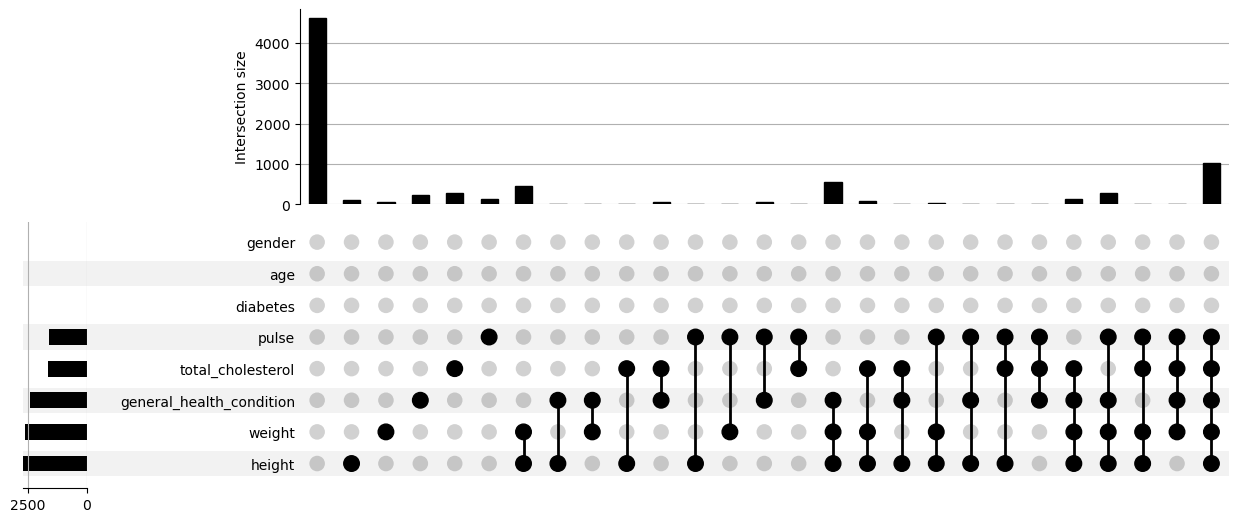

In [8]:
%run preprocesamiento_parte_1.ipynb

## Configurar el aspecto general de las gráficas del proyecto

In [9]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

## El problema de trabajar con valores faltantes

In [10]:
nhanes_df.describe()

,height,weight,total_cholesterol,pulse,diabetes,age
count,5488.000000,5553.000000,6565.000000,6570.000000,7157.000000,7157.000000
mean,66.256560,178.462993,179.673420,73.823135,0.119184,40.029761
std,4.157128,48.491693,40.544395,12.408720,0.324028,23.159479
min,49.000000,72.000000,76.000000,34.000000,0.000000,6.000000
25%,63.000000,145.000000,150.000000,66.000000,0.000000,17.000000
50%,66.000000,170.000000,175.000000,72.000000,0.000000,39.000000
75%,69.000000,205.000000,204.000000,82.000000,0.000000,61.000000
max,82.000000,484.000000,446.000000,136.000000,1.000000,80.000000


### Tres mecanismos de Valores Faltantes
1. Missing Completely At Random MCAR: La localización de los valores faltantes ocurren completamente a la azar, implicaría eliminar los valores faltantes, si se elimina no se introduce sesgos ya que se estan perdiendo completamente al azar.
2. Missing At Random MAR: La visualización de valores faltantes dependen de otros valores observados, por lo que ignorarlos produce sesgos. La mayor parte de metodos de imputación.
3. Missing Not At Random: La localización de los valores faltantes dependen de si mismos, ignorarlos genera sesgos, La imputación multiples de variable sirven para este tipo de mecanismos, realizar nuevos experimentos, analisis de sensibilidad. Establecer valores de confianza.

### Recomendaciones.
1. MCAR: Eliminación o imputación
2. MAR: Imputación Unica o Multiple
3. MNAR: Mejorar o sensibilizar

### Reto: Datos de supervivientes

In [11]:
survival_df = sm.datasets.get_rdataset("flchain", "survival").data

Ajusta algunos modelos utilizando a las variables con valores faltantes como predictoras. ¿Qué sucede?

## Evaluación del mecanismo de valores faltantes por prueba de _t-test_

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
<code>two-sided</code>: las <b>medias</b> de las distribuciones subyacentes a las muestras son <b>desiguales</b>.<br>
<code>less</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>menor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
<code>greater</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>mayor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
    </p>
</div>

#### Variables Genero y su relación con valores faltantes con las demas variables 

In [12]:
Female_weight, Male_weight = (
    nhanes_df
    .select_columns("gender","weight")
    .transform_column(
        "weight",
        lambda x: x.isna(),
        elementwise = False
    )
    .groupby("gender")
    .weight
    .pipe(
        lambda df: (df.get_group("Female"),
                    df.get_group('Male'))
    )
)

In [13]:
## Hipotesis nula: Los valores son iguales
## Hipotesis alterna: Los valores son desiguales
scipy.stats.ttest_ind(
    a = Female_weight,
    b = Male_weight,
    alternative = 'two-sided'
)

Ttest_indResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239)

#### Variable Edad y su relación con valores faltantes con las demas variables 

In [14]:
# Discretizar variable edad
from sklearn.preprocessing import KBinsDiscretizer

age_dis = KBinsDiscretizer(n_bins=3, encode='ordinal' , strategy = 'uniform').fit_transform(nhanes_df[['age']])
nhanes_df[['age_dis']] = age_dis

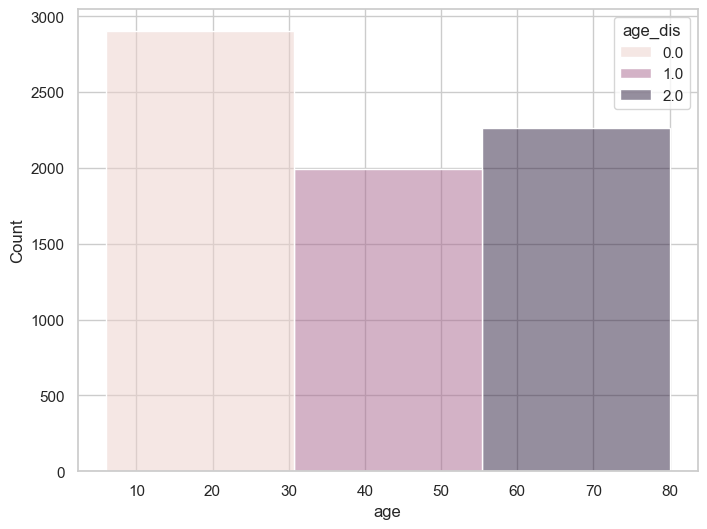

In [15]:
sns.histplot(data = nhanes_df[['age','age_dis']], hue = nhanes_df['age_dis'], x = 'age',bins = 3)
plt.show()

In [16]:
youngs, adults, olds = (
    nhanes_df
    .select_columns("age_dis","weight")
    .transform_column(
        "weight",
        lambda x: x.isna(),
        elementwise = False
    )
    .groupby("age_dis")
    .weight
    .pipe(
        lambda df: (df.get_group(0),
                    df.get_group(1),
                    df.get_group(2)
                   )
    )
)

In [17]:
## Hipotesis nula: Los valores son iguales
## Hipotesis alterna: Los valores son desiguales
scipy.stats.ttest_ind(
    a = youngs,
    b = adults,
    alternative = 'two-sided'
)

Ttest_indResult(statistic=44.55763280333797, pvalue=0.0)

In [18]:
## Hipotesis nula: Los valores son iguales
## Hipotesis alterna: Los valores son desiguales
scipy.stats.ttest_ind(
                    a = olds,
                    b = adults,
                    alternative = 'two-sided'
                    )

Ttest_indResult(statistic=-0.31193038445790244, pvalue=0.7551087209574089)

![](missing_data_action.jpeg)

## Amplía tu conjunto de herramientas para explorar valores faltantes

#### Mosaico

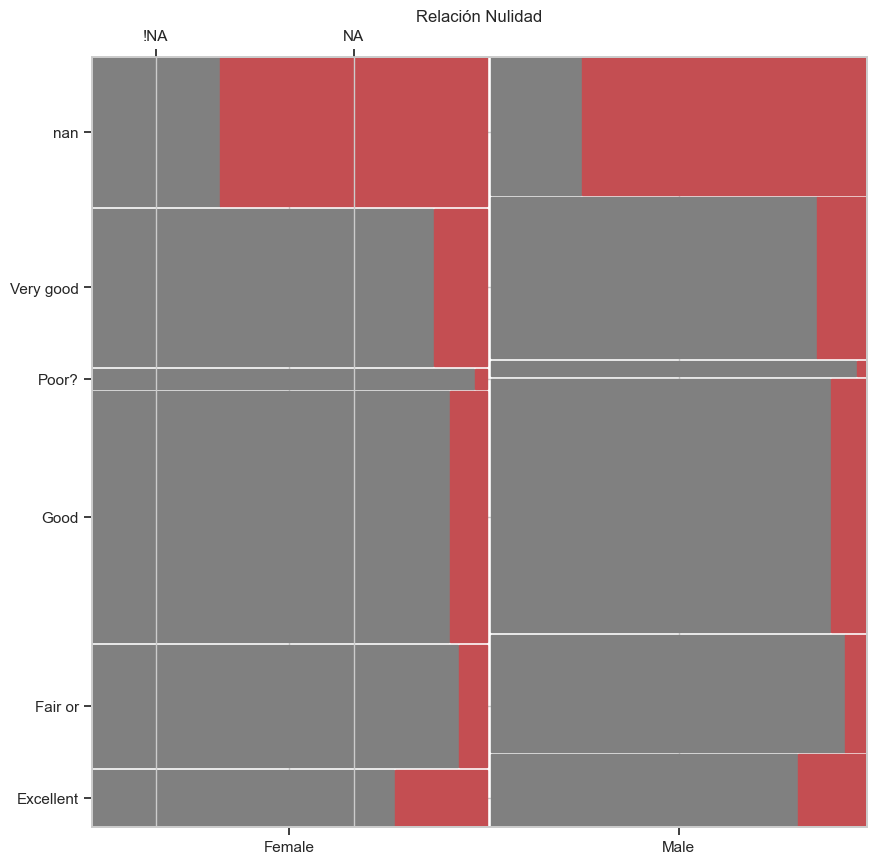

In [19]:
fig, ax = plt.subplots(figsize = (10,10))
(
    nhanes_df
    .select_columns("weight","general_health_condition","gender")
    .assign(
            weight = lambda df: df.weight.isna().replace([True,False],["NA","!NA"]) # retorna una serie de valores verdaderos y falsos
            )
    .groupby(
            ['gender','general_health_condition','weight'],
            dropna = False,
            as_index = True
            )
    .size()
    .pipe(
        lambda df: mosaic(
                        data = df,
                        properties = lambda key: {"color": "r" if "NA" in key else "gray"},
                        horizontal = True,
                        axes_label = True,
                        title = "Relación Nulidad",
                        labelizer = lambda key: "",
                        ax = ax
                         )
        )
);
plt.show()

## Tratamiento de variables categóricas para imputación de valores faltantes

### Codificación ordinal
Mapear cada entrada categorica en un valor ordinal numerico, se crea un proceso de codificación para usarlo como imputación.

Siempre crear una copia del dataframe para no perder los datos

In [20]:
nhanes_transform_df = nhanes_df.copy(deep = True)

### Codificación ordinal

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
    Una codificación ordinal <b>implica</b> mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.
    </p>
</div>

#### Ejemplo

Dado un conjunto de datos con dos características, encontraremos los valores únicos por cataracterística y los transformaremos utilizando una codificación ordinal.

In [21]:
X = [["Male"],["Female"],["Female"]]
X

[['Male'], ['Female'], ['Female']]

In [22]:
encoder = sklearn.preprocessing.OrdinalEncoder()

In [23]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [24]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [25]:
encoder.inverse_transform([[1],[0]])

array([['Male'],
       ['Female']], dtype=object)

#### Aplicando la codificación ordinal a todas tus variables categóricas

In [26]:
categorical_columns = nhanes_df.select_dtypes(include = [object,"category"]).columns

In [27]:
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder = 'passthrough'
)

In [28]:
nhanes_transform_df = (
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_transform_df),
        columns = categorical_transformer.get_feature_names_out(),
        index = nhanes_transform_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix('ordinalencoder__')
    )
    .rename_columns(
        function = lambda x: x.removeprefix('remainder__')
    )
)

### _One Hot Encoding_

In [29]:
nhanes_transform_df2 = nhanes_df.copy(deep = True)

### `pandas.get_dummies()` vs `skelearn.preprocessing.OneHotEncoder()`

#### `pandas.get_dummies()`

In [30]:
(
    nhanes_transform_df2
    .select_columns("general_health_condition")
#     .head(10)
    .pipe(pd.get_dummies)
)

,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
SEQN,,,,,
93705.0,0,0,1,0,0
93706.0,0,0,0,0,1
93707.0,0,0,1,0,0
93709.0,0,0,0,0,0
93711.0,0,0,0,0,1
...,...,...,...,...,...
102949.0,1,0,0,0,0
102953.0,0,1,0,0,0
102954.0,0,0,1,0,0


#### `skelearn.preprocessing.OneHotEncoder()`

In [31]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(),["gender"]),
    (sklearn.preprocessing.OneHotEncoder(),["general_health_condition"]),
    remainder = 'passthrough'
    )

In [32]:
nhanes_transform_df2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_transform_df2),
        columns = transformer.get_feature_names_out(),
        index = nhanes_transform_df2.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix('ordinalencoder__')
    )
    .rename_columns(
        function = lambda x: x.removeprefix('remainder__')
    )
    .rename_columns(
        function = lambda x: x.removeprefix('onehotencoder__')
    )
)

In [33]:
(
    transformer
    .named_transformers_
    .get('onehotencoder')
    .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [34]:
(
    transformer
    .named_transformers_
    .get('onehotencoder')
    .inverse_transform(
        X = [[0,0,1,0,0,0]]
    )
)

array([['Good']], dtype=object)

## Tipos de imputación de valores faltantes

#### Tipos de eliminaciones:
1. Pairwise deletion: Eliminación por parejas: Elimina unicamente los valores faltantes
2. Listwise deletion: Eliminación por filas con valores faltantes
3. Eliminación completa de columnas: elimina las columnas con valores faltantes
#### Tipos de imputaciones:
**IMPUTACIÓN GENERAL**
* Imputaciones para datos que no son series de tiempo
    + Imputación con una constante
    + Imputación con la media, mediana o moda
* Imputación para datos que son series de tiempo 
    + Llenado hacia atras
    + Llenado hacia delante
    + Interpolación

**IMPUTACIÓN AVANZADA**
* KNN
* MICE
* NN
* SVM
* OTROS MODELOS


Imputaciones basadas en el donante, completa los faltantes dando o copiando los valores observados de otra unidad, contrarío a un modelo que busca entrenarse para predecir el valor del conjunto de datos. 

In [35]:
nans_summary = (
    nhanes_df
    .isna()
    .sum()
    .reset_index(
                name = 'missing_values'
                )
    .rename(
            columns = {
                    'index': 'Variable'
            }
        )
    .assign(
        percentage = lambda df_reset: df_reset.missing_values / len(nhanes_df) * 100
    )
)
nans_summary

,Variable,missing_values,percentage
0,height,1669,23.319827
1,weight,1604,22.411625
2,general_health_condition,1360,19.002375
3,total_cholesterol,592,8.271622
4,pulse,587,8.201761
5,diabetes,0,0.000000
6,age,0,0.000000
7,gender,0,0.000000
8,age_dis,0,0.000000


Text(0, 0.5, 'Variable')

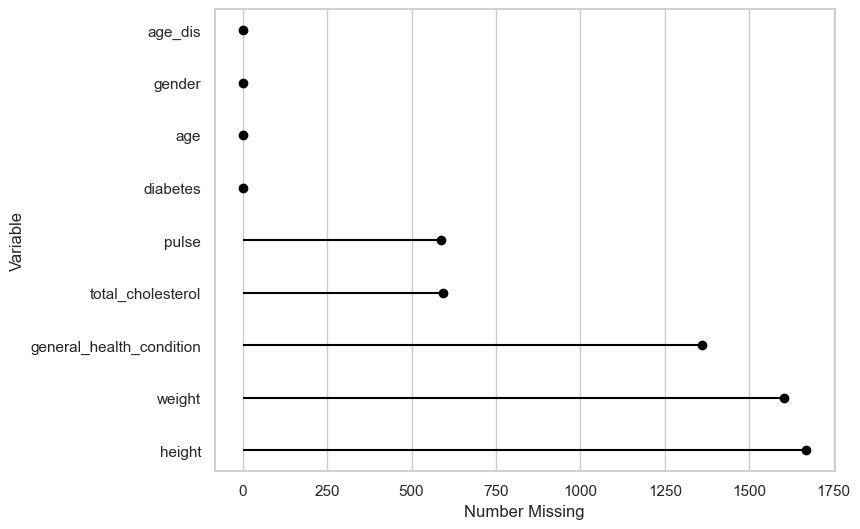

In [36]:
plot_range = range(1, len(nans_summary.index)+1)

plt.hlines(y = plot_range, xmin = 0, xmax = nans_summary.missing_values, color = 'black')
plt.plot(nans_summary.missing_values, plot_range,"o",color = 'black')
plt.yticks(plot_range, nans_summary.Variable)
plt.grid(axis = 'y')
plt.xlabel('Number Missing')
plt.ylabel('Variable')

<Axes: >

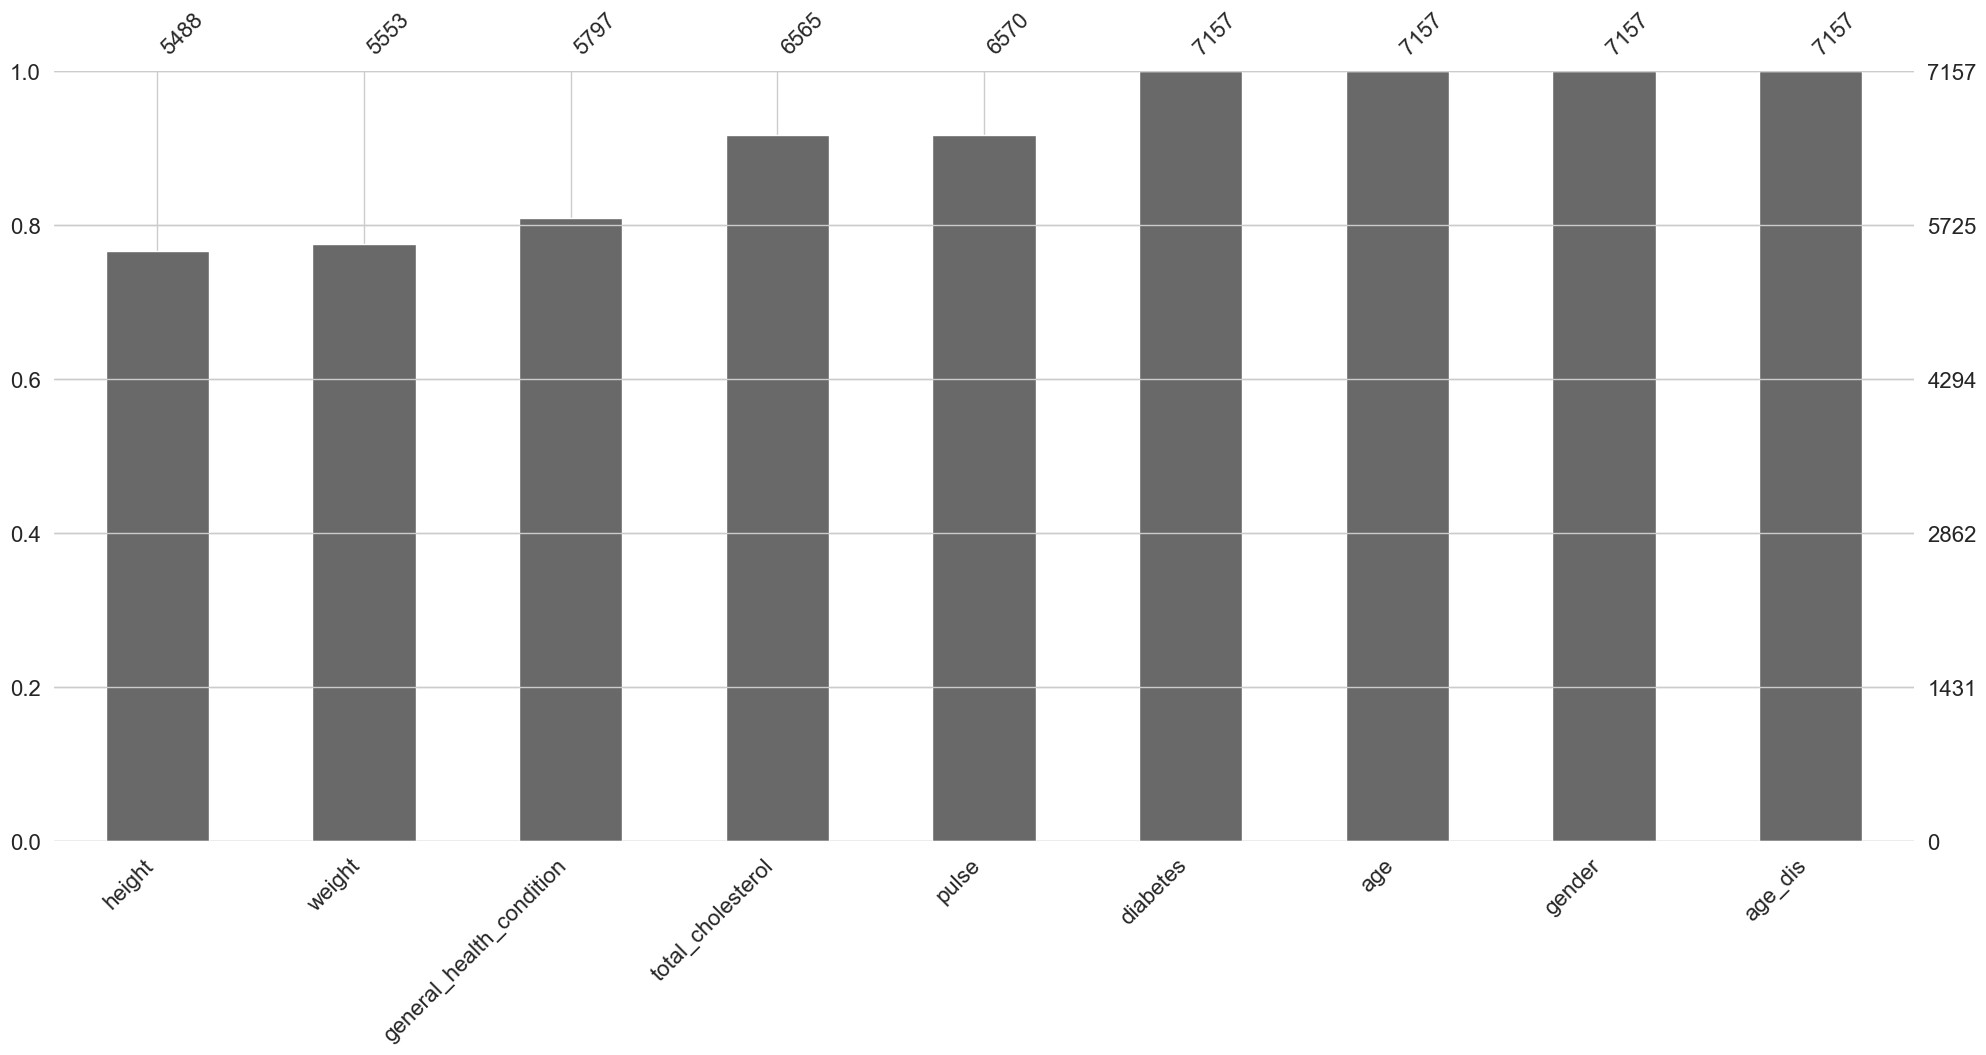

In [37]:
missingno.bar(df = nhanes_df)

<Axes: >

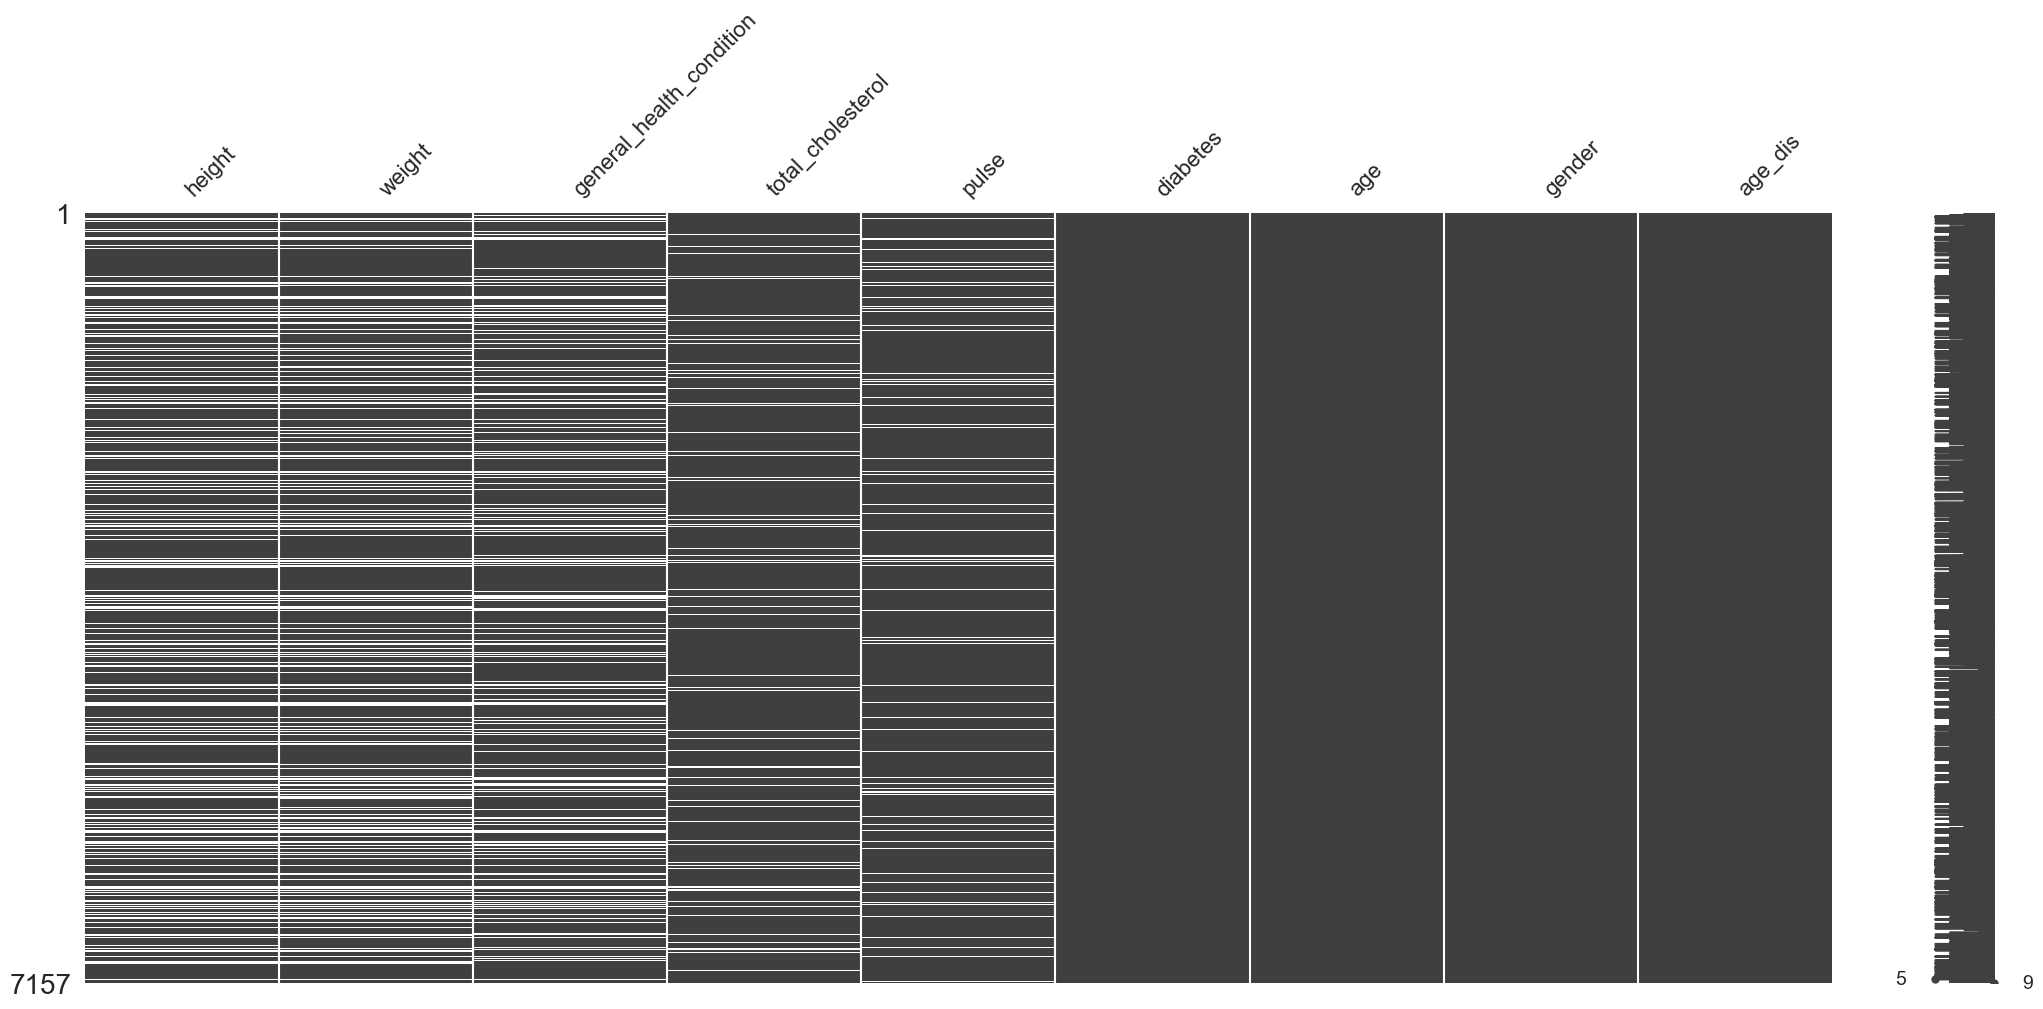

In [38]:
missingno.matrix(df = nhanes_df.missing.sort_variables_by_missingness())

In [39]:
shadow_matrix = (
    nhanes_df
    .isna()
    .pipe(lambda na_df: na_df[na_df.columns[na_df.any()]])
    .replace({ False: "Not_missing", True: "Missing"})
    .add_suffix('_NA')
    
)
shadow_matrix

,height_NA,weight_NA,general_health_condition_NA,total_cholesterol_NA,pulse_NA
SEQN,,,,,
93705.0,Not_missing,Not_missing,Not_missing,Not_missing,Not_missing
93706.0,Not_missing,Not_missing,Not_missing,Not_missing,Not_missing
93707.0,Missing,Missing,Not_missing,Not_missing,Not_missing
93709.0,Not_missing,Not_missing,Missing,Not_missing,Not_missing
93711.0,Not_missing,Not_missing,Not_missing,Not_missing,Not_missing
...,...,...,...,...,...
102949.0,Not_missing,Not_missing,Not_missing,Not_missing,Not_missing
102953.0,Not_missing,Not_missing,Not_missing,Not_missing,Not_missing
102954.0,Not_missing,Not_missing,Not_missing,Not_missing,Not_missing


In [40]:
nabular = pd.concat(
            objs = [nhanes_df,shadow_matrix],
            axis = "columns"
            )
nabular

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender,age_dis,height_NA,weight_NA,general_health_condition_NA,total_cholesterol_NA,pulse_NA
SEQN,,,,,,,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female,2.0,Not_missing,Not_missing,Not_missing,Not_missing,Not_missing
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male,0.0,Not_missing,Not_missing,Not_missing,Not_missing,Not_missing
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male,0.0,Missing,Missing,Not_missing,Not_missing,Not_missing
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female,2.0,Not_missing,Not_missing,Missing,Not_missing,Not_missing
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male,2.0,Not_missing,Not_missing,Not_missing,Not_missing,Not_missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male,1.0,Not_missing,Not_missing,Not_missing,Not_missing,Not_missing
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male,1.0,Not_missing,Not_missing,Not_missing,Not_missing,Not_missing
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female,1.0,Not_missing,Not_missing,Not_missing,Not_missing,Not_missing


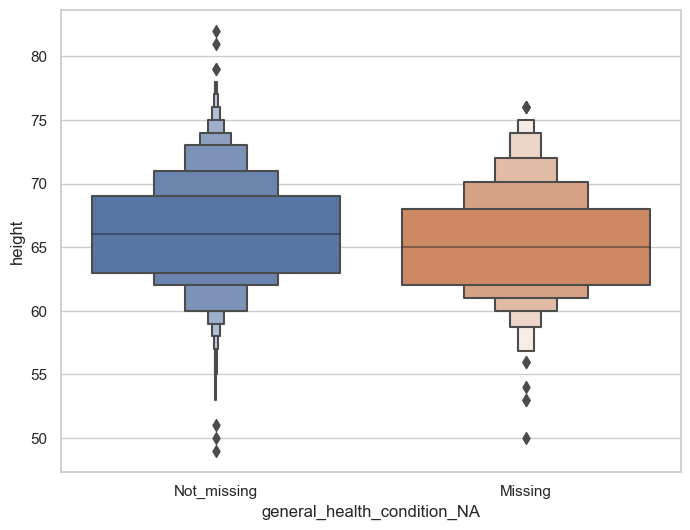

In [41]:
nabular.pipe(
    lambda data: (
    sns.boxenplot(
        data = data,
        x = 'general_health_condition_NA',
        y = 'height'
        )
    )

)
plt.show()

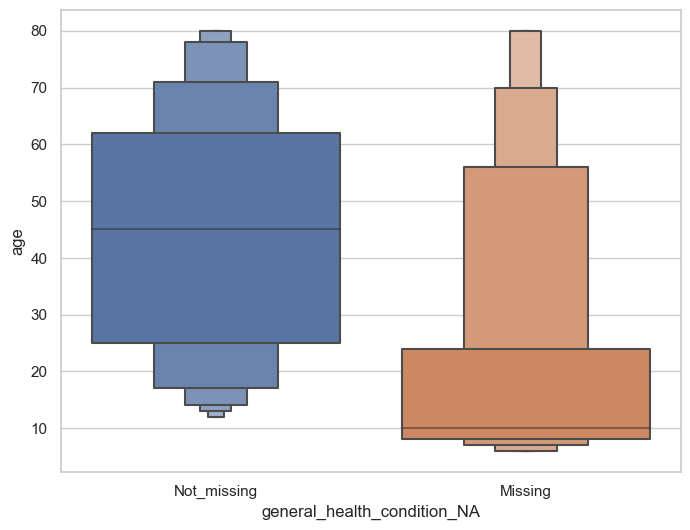

In [42]:
nabular.pipe(
    lambda data: (
    sns.boxenplot(
        data = data,
        x = 'general_health_condition_NA',
        y = 'age'
        )
    )

)
plt.show()

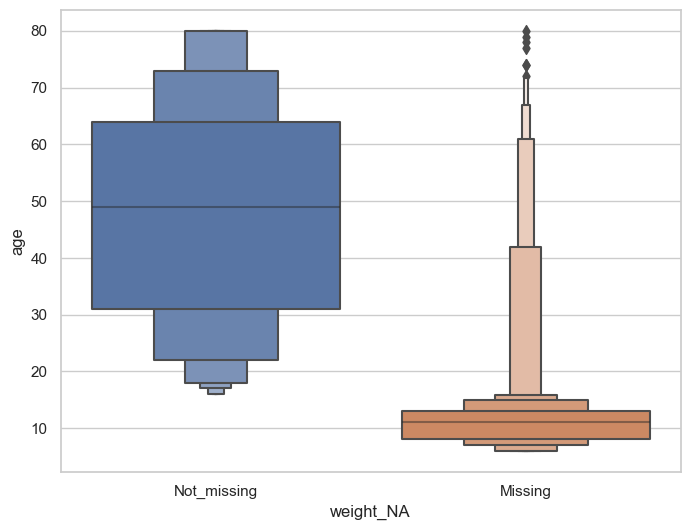

In [43]:
nabular.pipe(
    lambda data: (
    sns.boxenplot(
        data = data,
        x = 'weight_NA',
        y = 'age'
        )
    )

)
plt.show()

In [44]:
def column_fill_with_dummies(
                            column: pd.Series,
                            proportion_below: float = 0.10, # porcentaje a graficar de los datos
                            jitter: float = 0.075, # evitar el solapamiento de los datos.
                            seed: int=42,
                            jitter_value: int = 2
                            ) -> pd.Series:
    
    column = column.copy(deep=True)

    # Extract values metadata
    missing_mask = column.isna()
    number_missing_values = missing_mask.sum()
    column_range = column.max() - column.min()

    # Shift data
    column_shift = column.min() - column.min() * proportion_below
    
    # Create the "jitter" (noise) around the points
    np.random.seed(seed)
    column_jitter = (np.random.rand(number_missing_values) - jitter_value) * column_range * jitter

    # Save new dummy data
    column[missing_mask] = column_shift + column_jitter

    return column

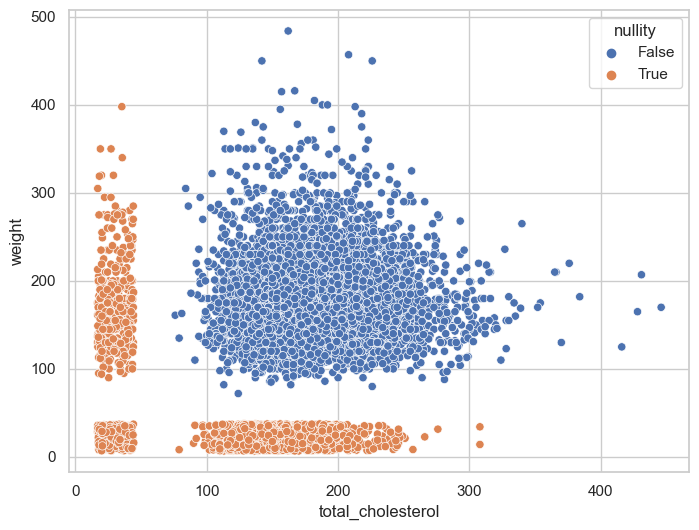

In [45]:
(
    nhanes_df
    .select_dtypes(
        exclude = 'object'
    )
    .pipe(
        lambda df: df[df.columns[df.isna().any()]]
    )
    .missing.bind_shadow_matrix(true_string = True, false_string = False) # generar una matriz de sombras de faltantes con true y false
    .apply(
        lambda column: column if "_NA" in column.name else column_fill_with_dummies(column, proportion_below = 0.05, jitter = 0.075)
    )
    .assign(
        nullity = lambda df: df.total_cholesterol_NA | df.weight_NA
    )
    .pipe(
    
        lambda df: (
            sns.scatterplot(
                data = df,
                x = 'total_cholesterol',
                y = 'weight',
                hue = 'nullity'
            )
        )
    )
)
plt.show()

<Axes: >

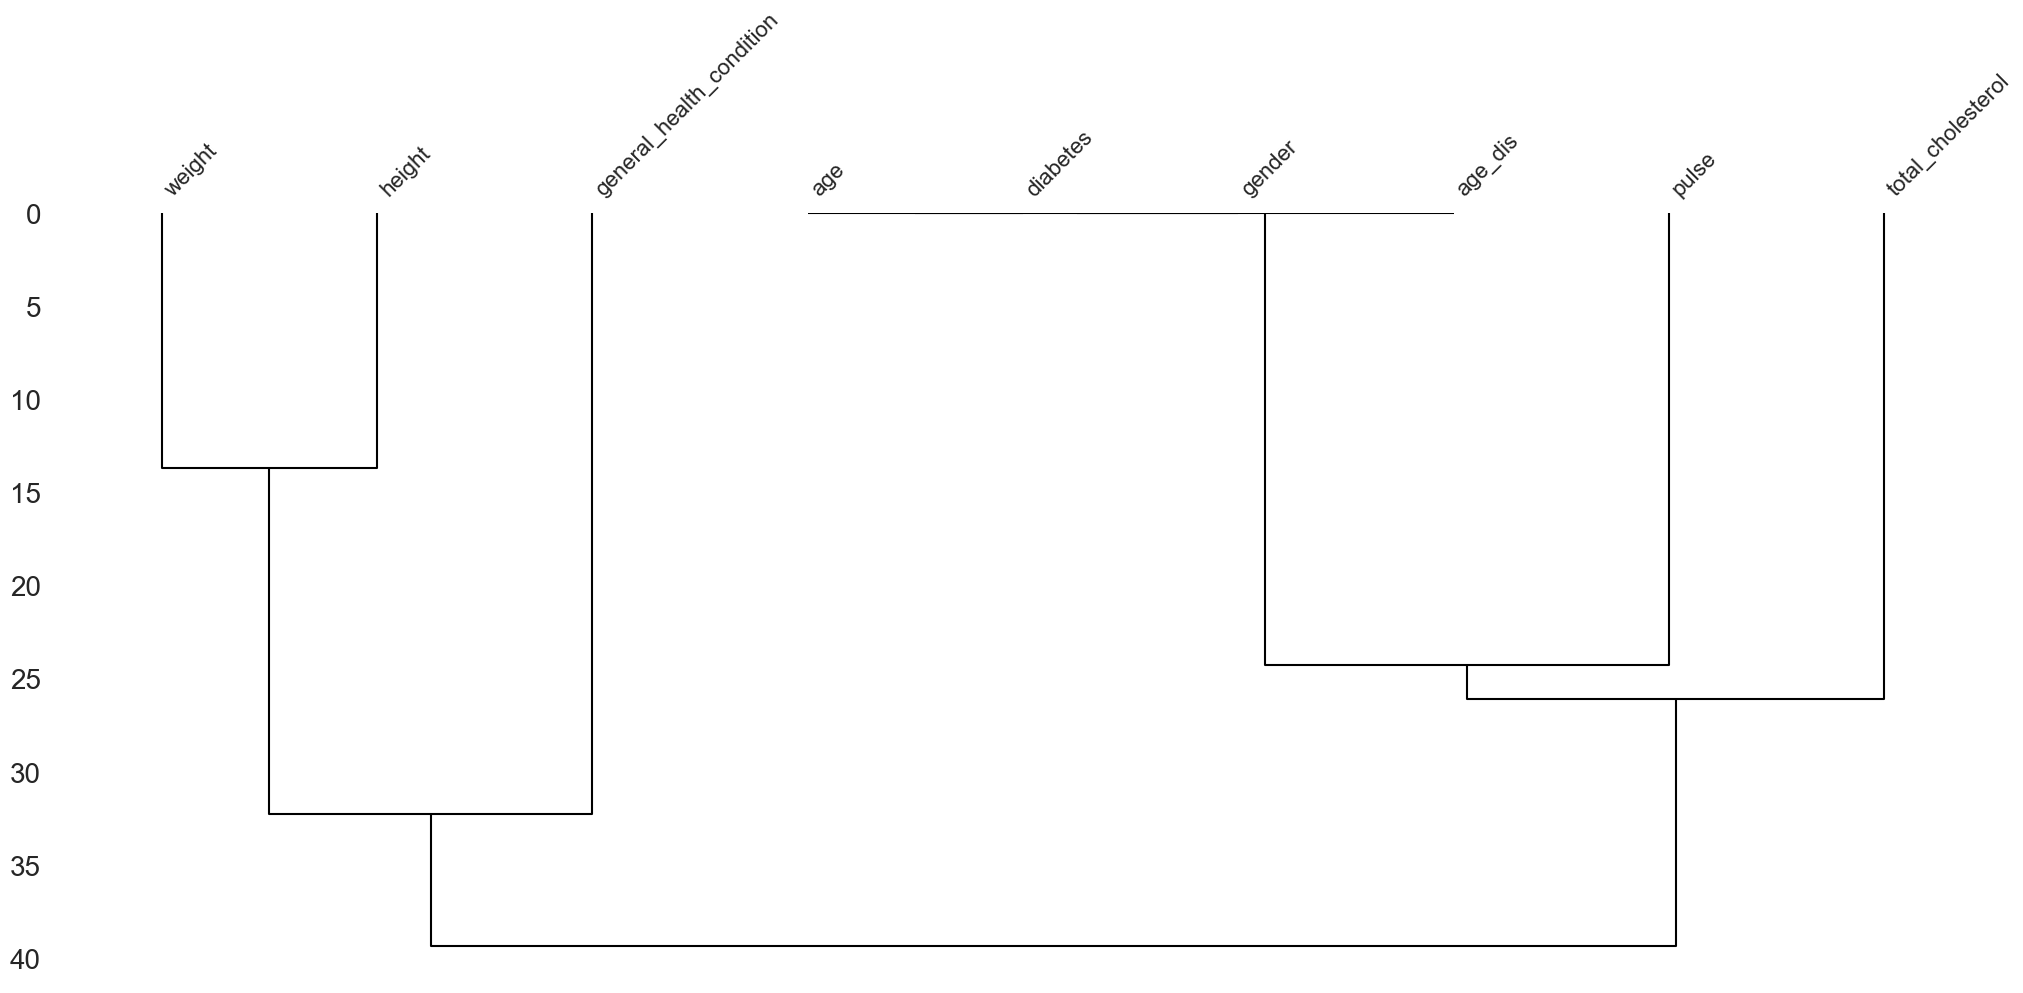

In [46]:
missingno.dendrogram(df = nhanes_df)

<Axes: >

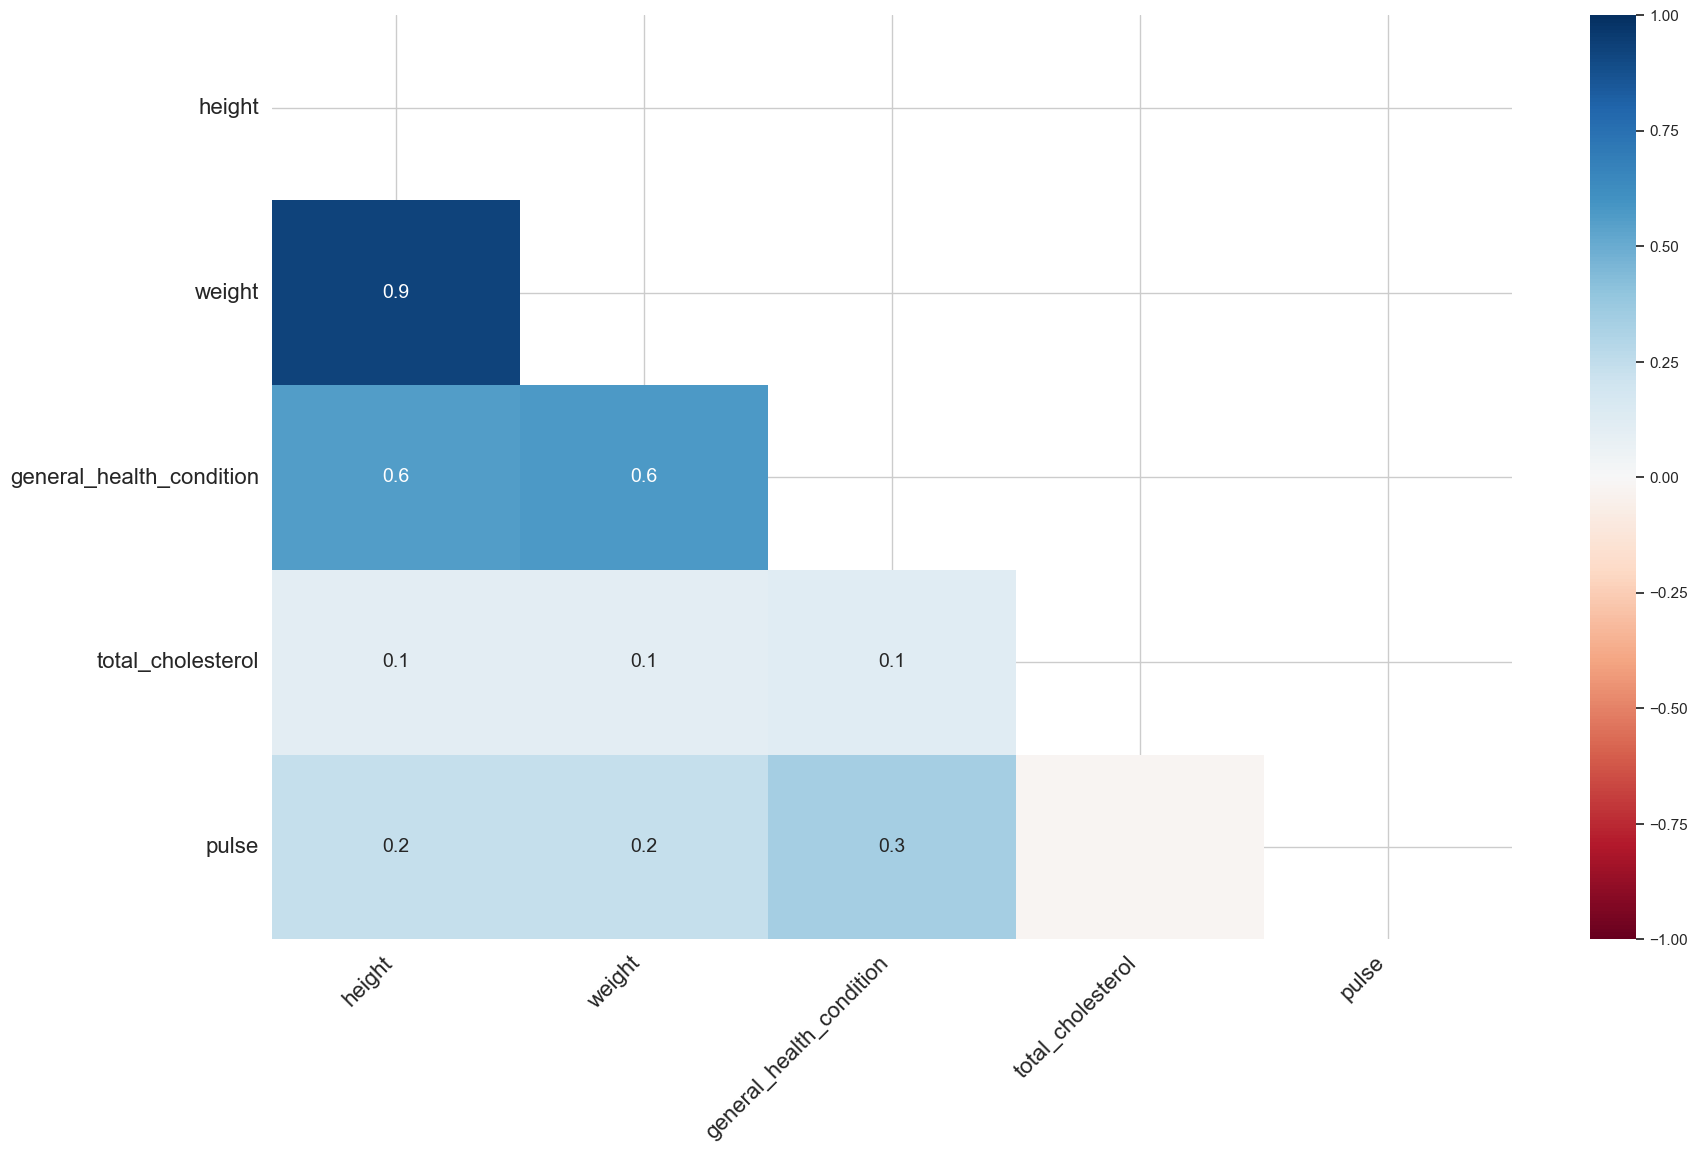

In [47]:
missingno.heatmap(df = nhanes_df)

## Imputación de un único valor (media, mediana, moda)

* Es rapido y fácil de usar, la media es util si tengo outliers en mis datos, los estadisticos se mantienen iguales
* Pero tambien puede modificar los datos y añadir sesgos, modifica la curtosis, modifica las correlaciones y no puede usarse variables categoricas

In [48]:
(
    nhanes_df
    .transform_column(
        'height',
        lambda x: x.fillna(x.mean()),
        elementwise = False # para cada elemento
    ).height.describe()
)

count    7157.000000
mean       66.256560
std         3.640204
min        49.000000
25%        64.000000
50%        66.256560
75%        68.000000
max        82.000000
Name: height, dtype: float64

<Axes: xlabel='height', ylabel='weight'>

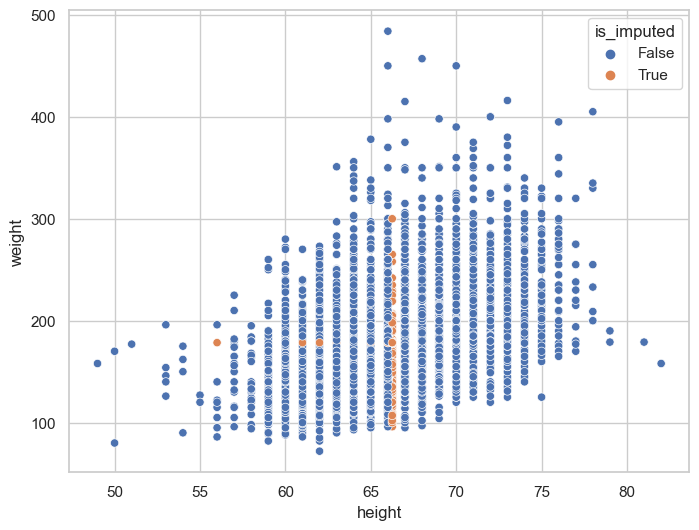

In [49]:
(
    nhanes_df
    .select_columns("height","weight")
    .missing.bind_shadow_matrix(True,False, suffix = '_imp')
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(
        x = 'height',
        y = 'weight'
    )
)

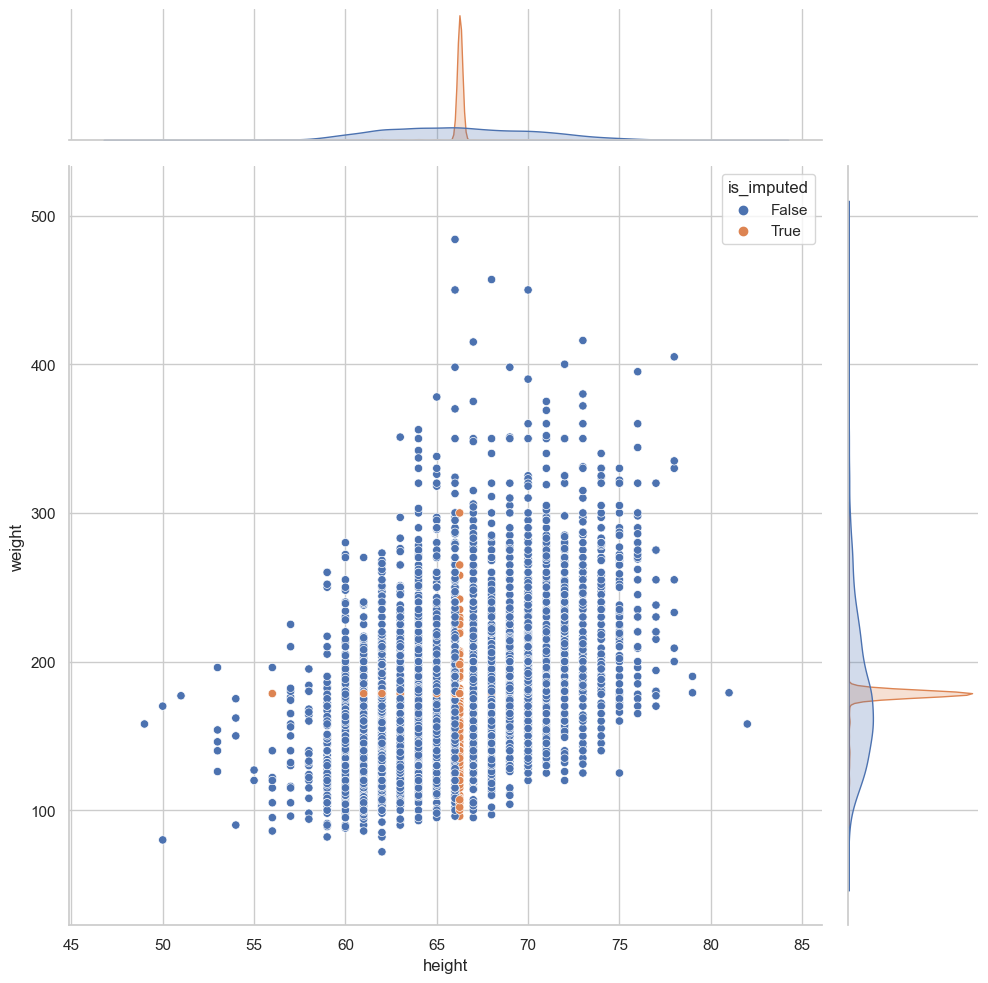

In [50]:
(
    nhanes_df
    .select_columns("height","weight")
    .missing.bind_shadow_matrix(True,False, suffix = '_imp')
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(
        x = 'height',
        y = 'weight',
        show_marginal = True,
        height = 10
    )
)

## Imputación por llenado hacia atrás e imputación por llenado hacia adelante

### `fillna()` vs `ffill()` o `bfill()`

In [51]:
(
    nhanes_df
    .select_columns('height',"weight")
    .fillna(method = 'ffill')
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,68.0,145.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [52]:
(
    nhanes_df
    .select_columns('height',"weight")
    .ffill()
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,68.0,145.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [53]:
(
    nhanes_df
    .select_columns('height',"weight")
    .bfill()
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,62.0,200.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


#### Recomendaciones al imputar valores utilizando `ffill()` o `bfill()`

> Imputación dentro de dominios e imputación a través de variables correlacionadas

In [54]:
(
    nhanes_df
    .select_columns("weight","height","gender","diabetes","general_health_condition")
    .sort_values(
        by = ['gender','diabetes','general_health_condition','height'],
        ascending = True
    )
    .transform_column(
        'weight',
        lambda x: x.ffill(),
        elementwise = False #Para que pase una serie y no un unico valor
    )
)

,weight,height,gender,diabetes,general_health_condition
SEQN,,,,,
94421.0,115.0,56.0,Female,0,Excellent
94187.0,130.0,59.0,Female,0,Excellent
95289.0,162.0,59.0,Female,0,Excellent
97967.0,130.0,59.0,Female,0,Excellent
99125.0,105.0,59.0,Female,0,Excellent
...,...,...,...,...,...
96561.0,290.0,74.0,Male,1,NaN
96954.0,175.0,NaN,Male,1,NaN
97267.0,175.0,NaN,Male,1,NaN


In [55]:
(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by=['gender','diabetes','general_health_condition','weight'],
        ascending=True
    )
    .groupby(["gender", "general_health_condition"], dropna=False)
    .apply(lambda x: x.ffill())
)

C:\Users\FRLUENGA\AppData\Local\Temp\ipykernel_14552\909901090.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  nhanes_df


,height,weight,gender,diabetes,general_health_condition
SEQN,,,,,
94195.0,63.0,90.0,Female,0,Excellent
95793.0,61.0,96.0,Female,0,Excellent
101420.0,59.0,98.0,Female,0,Excellent
94148.0,65.0,100.0,Female,0,Excellent
102062.0,62.0,100.0,Female,0,Excellent
...,...,...,...,...,...
96561.0,74.0,290.0,Male,1,NaN
96869.0,72.0,298.0,Male,1,NaN
97267.0,72.0,298.0,Male,1,NaN


## Imputación por interpolación
* Muy util para series de tiempo
* Sencillo de implementar
* Variabilidad de opciones

pero puede romper relaciones entre variables y puede introducir valores fuera de rango

In [56]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")
    .data
    .clean_names(
        case_type = "snake"
    )
    .add_column("year", 1973)
    .assign(
        date = lambda df: pd.to_datetime(df[["year", "month", "day"]])
    )
    .sort_values(by = "date")
    .set_index("date")
)

airquality_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

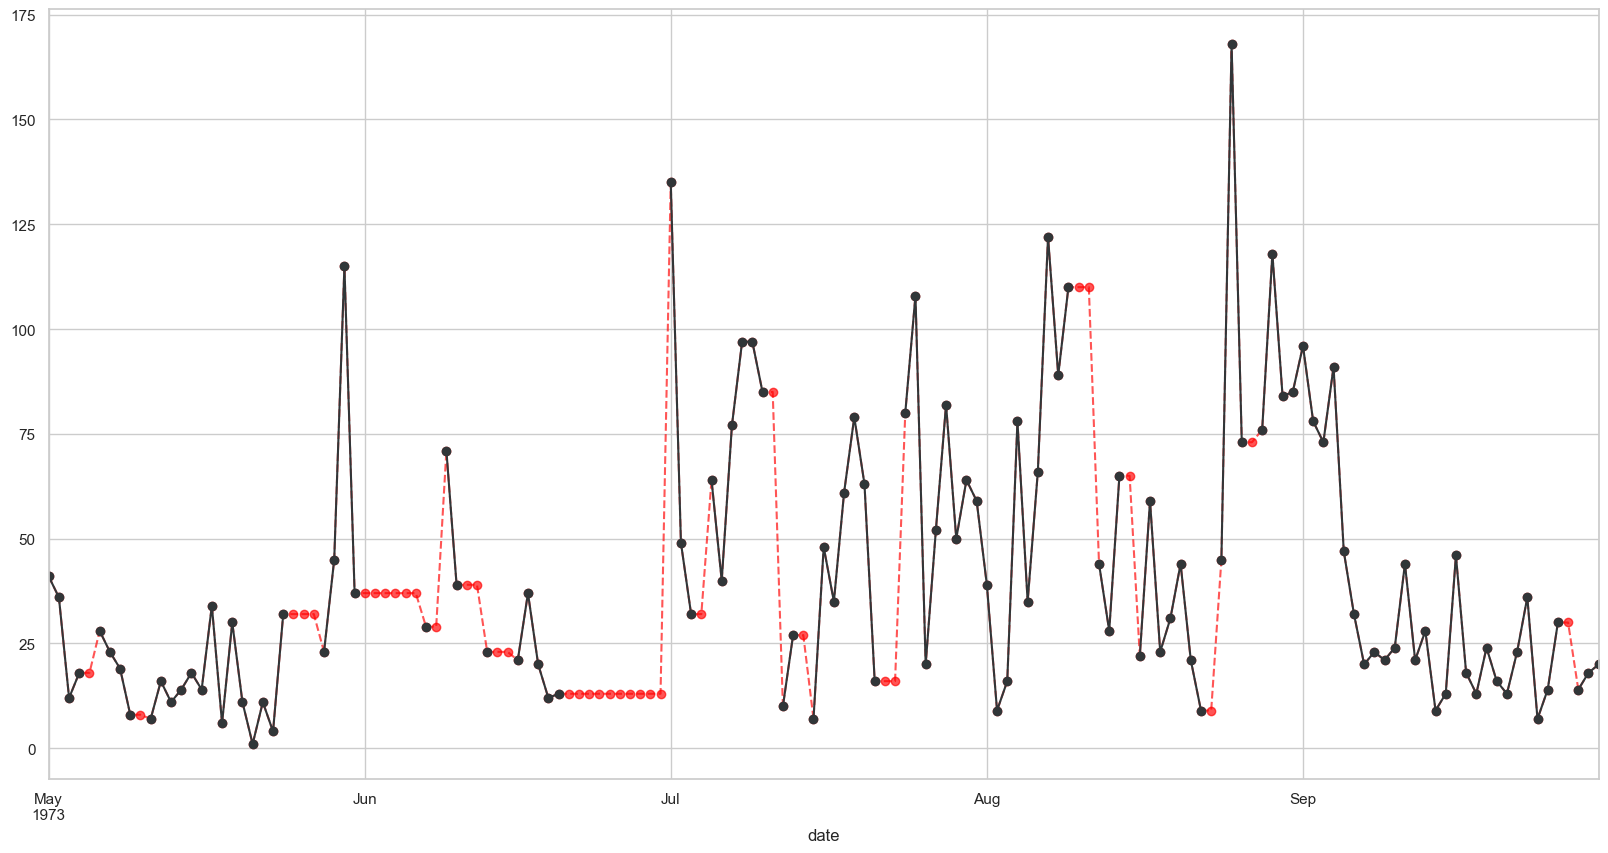

In [57]:
plt.figure(figsize = (20,10))
(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df: (
            df.ozone.ffill().plot(color = 'red', marker = 'o', alpha = 6/9, linestyle = 'dashed'),
            df.ozone.plot(color = '#313638', marker = 'o')
        )
    )
)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

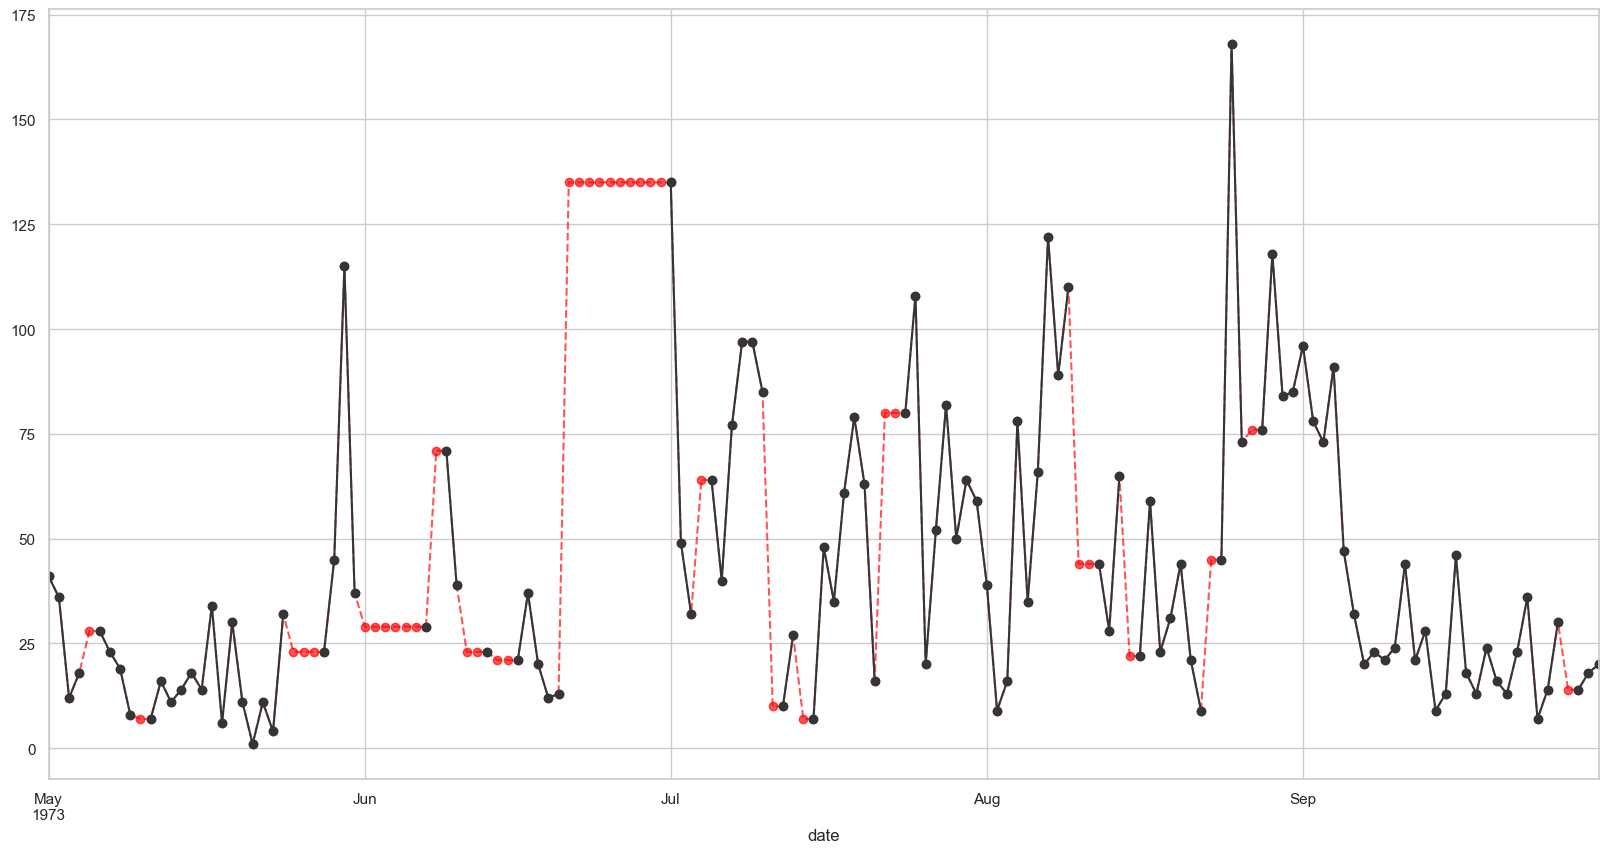

In [58]:
plt.figure(figsize = (20,10))
(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df: (
            df.ozone.bfill().plot(color = 'red', marker = 'o', alpha = 6/9, linestyle = 'dashed'),
            df.ozone.plot(color = '#313638', marker = 'o')
        )
    )
)

#### Imputación por interpolación:
    Usar puntos conocidos para estimar los puntos desconocidos.

<Axes: xlabel='date'>

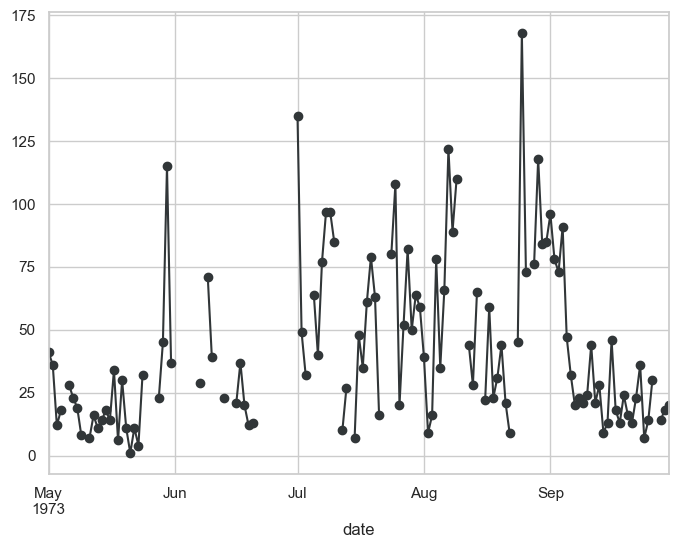

In [59]:
(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df: df.ozone.plot(color = "#313638",
                                marker = 'o'
                                )
    )
)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

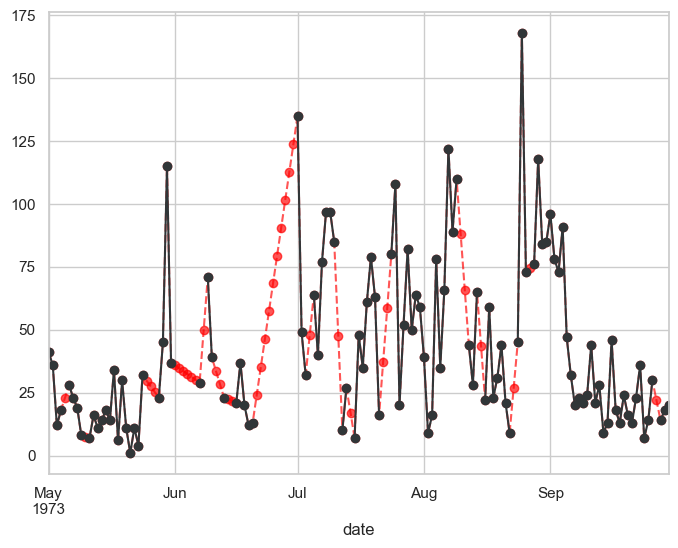

In [60]:
(
    airquality_df
    .select_columns('ozone')
    .pipe(
               
        lambda df: (
            df.ozone.interpolate(method = 'linear').plot(color = 'red', marker = 'o', alpha = 6/9, linestyle = 'dashed'),
            df.ozone.plot(color = "#313638",marker = 'o'
                                ))
    )
)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

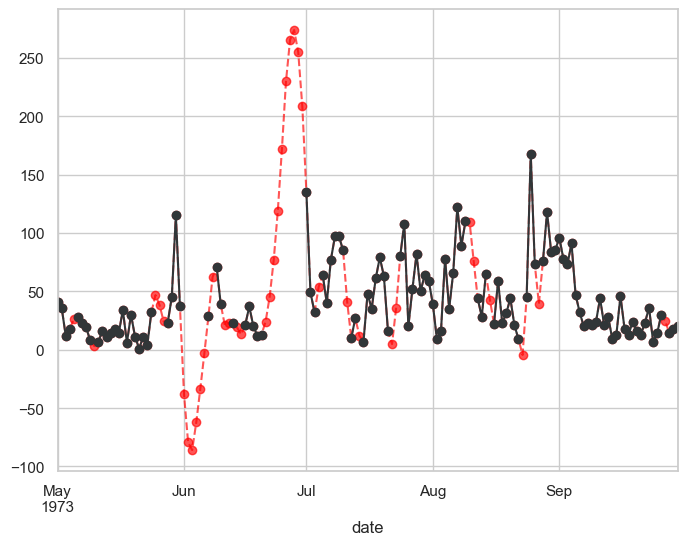

In [61]:
(
    airquality_df
    .select_columns('ozone')
    .pipe(
               
        lambda df: (
            df.ozone.interpolate(method = 'quadratic').plot(color = 'red', marker = 'o', alpha = 6/9, linestyle = 'dashed'),
            df.ozone.plot(color = "#313638",marker = 'o'
                                ))
    )
)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>, <Axes: xlabel='date'>)

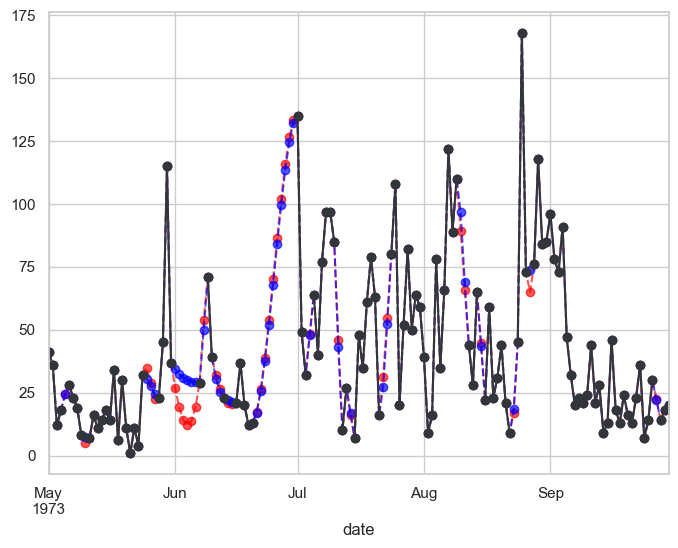

In [62]:
(
    airquality_df
    .select_columns('ozone')
    .pipe(
               
        lambda df: (
            df.ozone.interpolate(method = 'akima').plot(color = 'red', marker = 'o', alpha = 6/9, linestyle = 'dashed'),
            df.ozone.interpolate(method = 'pchip').plot(color = 'blue', marker = 'o', alpha = 6/9, linestyle = 'dashed'),
            df.ozone.plot(color = "#313638",marker = 'o'
                                ))
    )
)

(<Axes: xlabel='date'>, <Axes: xlabel='date'>)

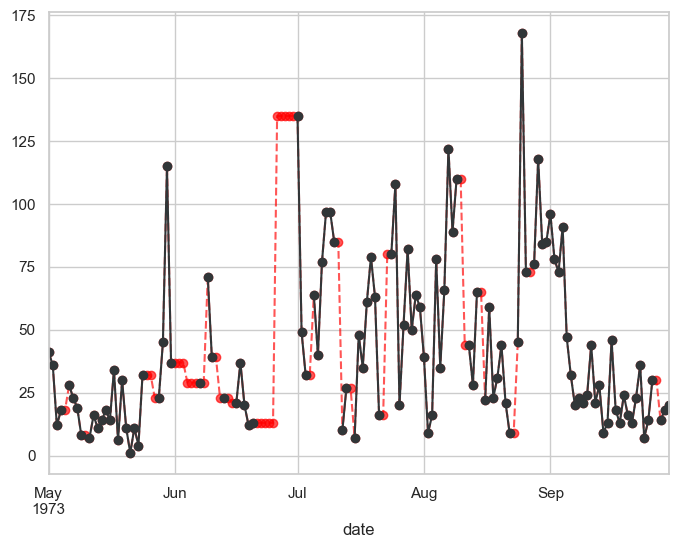

In [63]:
(
    airquality_df
    .select_columns('ozone')
    .pipe(
               
        lambda df: (
            df.ozone.interpolate(method = 'nearest').plot(color = 'red', marker = 'o', alpha = 6/9, linestyle = 'dashed'),
            df.ozone.plot(color = "#313638",marker = 'o'
                                ))
    )
)

In [64]:
airquality_df['ozone'] = airquality_df.ozone.interpolate(method = 'pchip')

## Imputación por algoritmo de vecinos más cercanos (KNN)

Para cada observación con valores faltantes
1. encuentra otras k observaciones (donadores, vecinos) que sean mas similares a esa observación.
2. Reemplaza los valores faltantes con los valores agregados de los k vecinos.

Se identifica a través de metricas de distancia, para identificar que tan lejos o cerca estas entre las observaciones.
- para variables numericas, se usa la euclidiana.
- para variables tipo factores, se usa la distancia absoluta, a través de la distancia manhattan.
- para variables categoricas puras, se usa la distancia de hamming, e.g. cuantifica la diferencia entre los textos. Comparación bit a bit.
- se puede unir todas estas metricas para conjunto de datos mixtos con la metrica de distancia de gower.

1. En general puede ser sencible a valores atipicos.
2. Tambien es sensible a la escala de los datos, se recomienda escalar o estandarizar los datos
3. El modulo de sklearn usa por defecto la distancia euclidiana.

### Ordenamiento por cantidad de variables faltantes

In [68]:
# nhanes_transform_df.drop(['age_dis'],axis = 1, inplace = True)

knn_imputer = sklearn.impute.KNNImputer()

nhanes_df_knn = nhanes_transform_df.copy(deep = True)

nhanes_df_knn.iloc[:,:] = knn_imputer.fit_transform(nhanes_transform_df).round()
nhanes_df_knn

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,69.0,130.0,189.0,100.0,0.0,13.0
93709.0,2.0,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


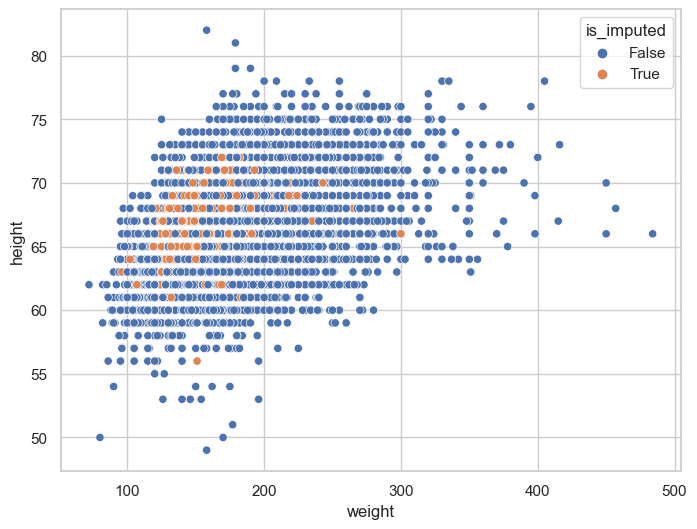

In [70]:
(
    pd.concat(
        [nhanes_df_knn,
        nhanes_df.missing.create_shadow_matrix(True, False, suffix = '_imp',only_missing = True)
        ], axis = 1
    )
    .missing.scatter_imputation_plot(
        x = 'weight',
        y = 'height'
    )
)
plt.show()

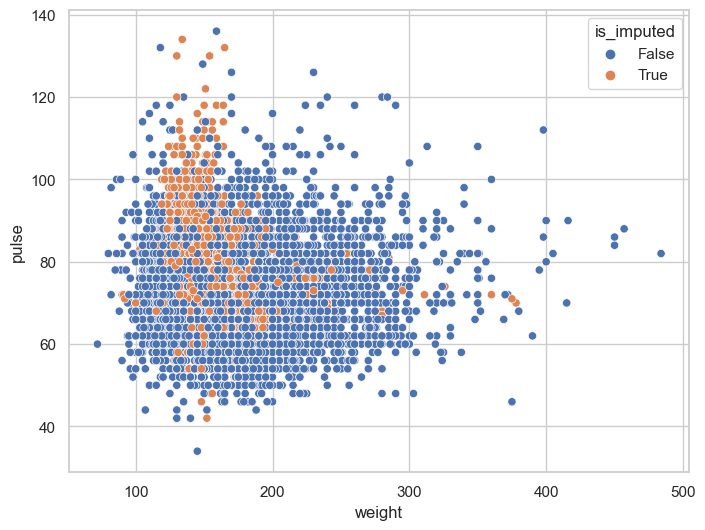

In [75]:
(
    pd.concat(
        [nhanes_df_knn,
        nhanes_df.missing.create_shadow_matrix(True, False, suffix = '_imp',only_missing = True)
        ], axis = 1
    )
    .missing.scatter_imputation_plot(
        x = 'weight',
        y = 'pulse'
    )
)
plt.show()

In [73]:
knn_imputer = sklearn.impute.KNNImputer()

nhanes_df_knn = nhanes_transform_df.missing.sort_variables_by_missingness(ascending = True).copy(deep = True)

nhanes_df_knn.iloc[:,:] = knn_imputer.fit_transform(nhanes_transform_df.missing.sort_variables_by_missingness(ascending = True)).round()
nhanes_df_knn

,gender,diabetes,age,pulse,total_cholesterol,general_health_condition,weight,height
SEQN,,,,,,,,
93705.0,0.0,0.0,66.0,52.0,157.0,2.0,165.0,63.0
93706.0,1.0,0.0,18.0,82.0,148.0,4.0,145.0,68.0
93707.0,1.0,0.0,13.0,100.0,189.0,2.0,130.0,69.0
93709.0,0.0,0.0,75.0,74.0,176.0,2.0,200.0,62.0
93711.0,1.0,0.0,56.0,62.0,238.0,4.0,142.0,69.0
...,...,...,...,...,...,...,...,...
102949.0,1.0,0.0,33.0,96.0,201.0,0.0,180.0,72.0
102953.0,1.0,0.0,42.0,78.0,182.0,1.0,218.0,65.0
102954.0,0.0,0.0,41.0,78.0,172.0,2.0,150.0,66.0


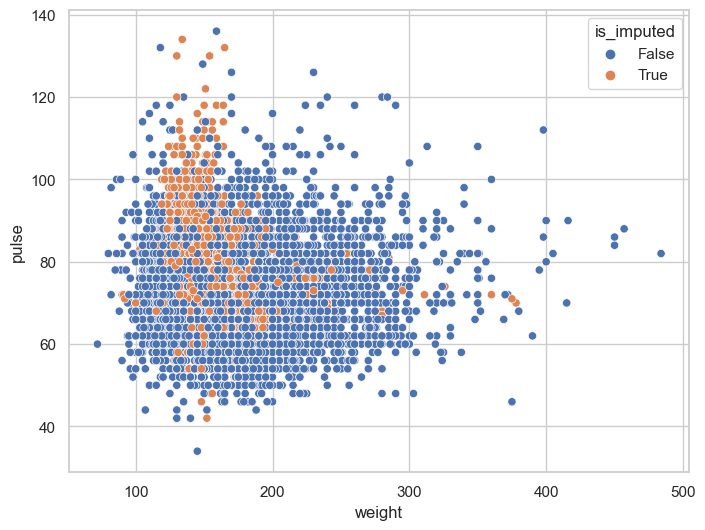

In [74]:
(
    pd.concat(
        [nhanes_df_knn,
        nhanes_df.missing.create_shadow_matrix(True, False, suffix = '_imp',only_missing = True)
        ], axis = 1
    )
    .missing.scatter_imputation_plot(
        x = 'weight',
        y = 'pulse'
    )
)
plt.show()

## Imputación basada en modelos
1. Puede subestimar la varianza de los datos.
2. Los modelos funcionan mal si las variables observadas y faltantes son independientes, y es mas complicado que la imputación basada en donantes

Sin embargo, esto mejora la imputación basada en donantes sencilla y tiene gran variedad de opciones a imputar, busca preservar la relación entre variables.

In [91]:
nhannes_model_df = (
    nhanes_df
    .select_columns('height','weight','age','gender')
    .sort_values(by = 'height')
    .transform_column(
        'weight',
        lambda x: x.ffill(),
        elementwise = False
    )
    .missing.bind_shadow_matrix(
        True,
        False,
        suffix = '_imp',
        only_missing = False
    )
)

In [92]:
height_ols = (
    nhannes_model_df
    .pipe(
        lambda df: smf.ols("height ~ weight + gender + age", data = df)
    )
    .fit()
)

In [93]:
ols_imputed_value = (
    nhannes_model_df
    .pipe(
        lambda df: df[df.height.isna()]
    )
    .pipe(
        lambda df: height_ols.predict(df).round()
    )
)

In [94]:
nhannes_model_df.loc[nhannes_model_df.height.isna(), ['height']] = ols_imputed_value

<Axes: xlabel='weight', ylabel='height'>

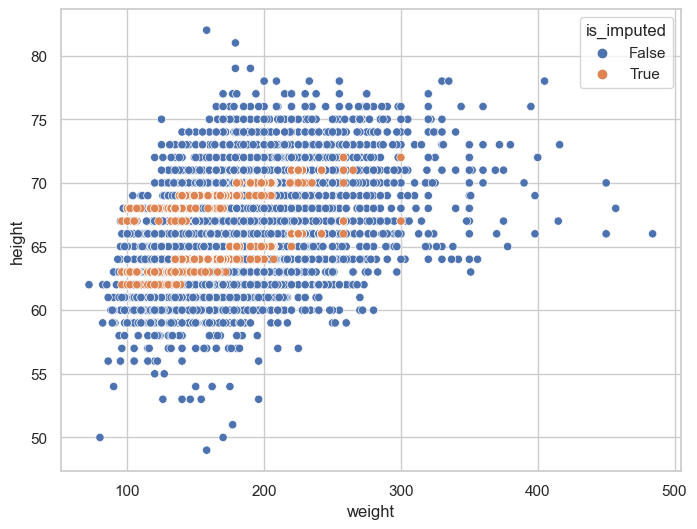

In [95]:
(
    nhannes_model_df
    .missing
    .scatter_imputation_plot(
        x = 'weight',
        y = 'height'
    )
)

## Imputaciones Múltiples por Ecuaciones Encadenadas (MICE)

1. Crear copias del conjunto de datos imputando valores faltantes
2. Se analizan los resultados, para crear un informe con intervalos de confiabilidad.
3. Se agrupan resultados.

- Predecir variables de valores faltantes en función de las variables completas.
- Con el valor nuevo imputado se usará como valor completo para la siguiente variable con valores faltantes hasta lograr completar el conjunto de datos completo.

Ventajas:

Mantiene la distribución relativa, puede usarse en cualquier tipo de analisis, MCAR MAR MNAR. Todas las variables son imputadas.

Desventajas:
Trabajo para seleccionar el modelo de imputación y el analisis de los resultados, que tenga sentido y relación. Solo funciona para metodos de imputación seleccionados.

In [97]:
mice_imputer = sklearn.impute.IterativeImputer(
        estimator = BayesianRidge(),
        initial_strategy = 'mean',
        imputation_order = 'ascending'
)

In [103]:
nhanes_mice_df = nhanes_transform_df.copy(deep = True)
nhanes_mice_df.iloc[:,:] = mice_imputer.fit_transform(nhanes_transform_df).round()

In [107]:
nhannes_mice_df = (
    pd.concat(
        [nhanes_mice_df,
        nhanes_df.missing.create_shadow_matrix(True, False, suffix = '_imp',only_missing = True)
        ],
        axis = 1
    )
)

<Axes: xlabel='height', ylabel='weight'>

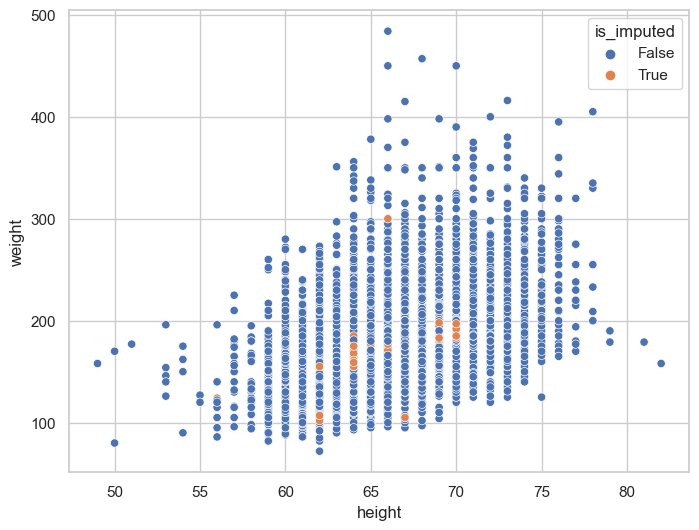

In [108]:
(
    nhannes_mice_df
    .missing.scatter_imputation_plot(
        x = 'height',
        y = 'weight'
    )
)

## Transformación inversa de los datos

In [110]:
nhanes_imputed_df = nhanes_mice_df.copy(deep = True)

In [117]:
nhanes_imputed_df[categorical_columns] = (
    categorical_transformer
    .named_transformers_
    .ordinalencoder
    .inverse_transform(
        X = nhanes_mice_df[categorical_columns]
    )
)

In [118]:
nhanes_imputed_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,Good,Female,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,Very good,Male,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,Good,Male,70.0,200.0,189.0,100.0,0.0,13.0
93709.0,Good,Female,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,Very good,Male,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,Excellent,Male,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,Fair or,Male,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,Good,Female,66.0,150.0,172.0,78.0,0.0,41.0


## Continúa aprendiendo sobre el manejo de valores faltantes

<div class="alert alert-success">
    <b style="font-size: 1.5em;">✅ ¡Felicidades por terminar el curso!</b>
    <p>
    ¡Tu progreso es increíble! ¡Ahora eres capaz de llevar tus análisis al siguiente nivel! La barrera de los valores faltantes ya no es una limitante extrema para tu trabajo. Tú puedes explorar valores faltantes, eliminarlos e imputarlos siendo consciente de las ventajas y desventajas de cada método elegido. ¡Fantástico!
    </p>
    <p>
    <b>¿Cómo puedo continuar mi aprendizaje en el análisis de valores faltantes?</b>
    Poner en práctica lo aprendido es una excelente opción. Por lo tanto, te recomiendo repetir este curso utilizando la totalidad de los datos del <i>National Health and Nutrition Examination Survey</i>. Con este proyecto, serás capaz de explorar y analizar una cantidad de valores faltantes variadas. Podrás probar distintos algoritmos y estrategias. 
    </p>
    <p>
    De tal forma de que, una vez consigas tu conjunto de datos final, puedas proceder a la exploración definitiva del conjunto de datos para extraer ideas y respuestas a preguntas de tu interés. Incluso, y por qué no, podrías explorar la posibilidad de crear modelos predictivos para la diabetes. Las opciones son ilimitadas. Bienvenido al mundo de la Ciencia de Datos.
    </p>
    <p>
    Con mucha alegría por tu logro,
    Jesús Vélez Santiago
    </p>
</div>

## Información de sesión

In [96]:
session_info.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bdf84ff9-f66c-44c7-a67c-ca1115a2b683' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>